# Pulse Shaping Simulation

 TODO
 - realistische Dimensionen
 - andere Amplituden: Summe von Gauss-Kurven
 - Wechselwirkung mit anharmonischem Oszillator (typisches Molekülpotential)

In [1]:
import numpy as np  # 1.21.5
from typing import NamedTuple 
import matplotlib.pyplot as plt
import imagesc as imagesc
#import pandas as pd
import librosa
import librosa.display
import scipy
import os

from berechneFWHM import berechneFWHM
from calcWidthFromVector import calcWidthFromVector
from fminCallback import fminCallback
from normPhase import normPhase
from phasePulseFormer import phasePulseFormer
from plotOptimState import plotOptimState
from shgValue import shgValue
from targetFunc import targetFunc
from xcorrSpectrogram import xcorrSpectrogram


Reference width: 0.707107

Reference shg: 79.788455

width before: 1.936492

shg before: 30.481931



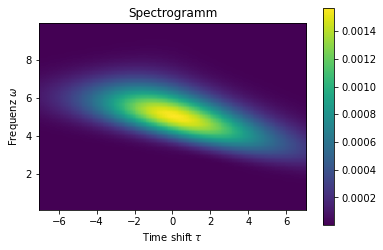

In [2]:
## Setup

# Setup Values
gdd = 2.5                   # Second order dispersion
tod = -1                    # Third order dispersion 
sigma = 1                   # width of frequency function
wp = 5                      # Midpoint of frequency function
nPix = 640                  # number of pixels of pulse shaper
samplesPerPeriod = 20       # samples per period in time domain
shaperLims = [wp - 4*sigma, wp + 4*sigma]
Tp = 2*np.pi/wp
tLim = 15
tauVec = np.linspace(-7, 7, 100)
S = 4                      # number of spline support points

# Construction of frequency axis: nPix samples in shaper-interval
w0 = (shaperLims[1] - shaperLims[0]) / nPix     # frequency resolution
NN = np.ceil(2*np.pi/(Tp*w0)*samplesPerPeriod)
ww = np.arange(0,(NN))*w0     # Frequency axis
startIdx = np.argwhere(ww < shaperLims[0])
startIdx = np.reshape(startIdx,(1,len(startIdx)))
startIdx = startIdx[0][-1] + 1
ws = NN * w0        # sample rate 
Ts = 2*np.pi / ws   # sample time
T0 = 2*np.pi/w0     # duration in time domain
tt = -T0/2 + np.arange(0,(NN))*Ts     # time axis shifted so that it centers around 0


# Lambda Funktionen:
phaseFunc = lambda w: - gdd/2 * np.power((w-wp),2) + tod/6*np.power((w-wp),3)
Apos = lambda w, phaseFunc: np.exp(-(np.power((w-wp),2)) / (2*np.power(sigma,2)) + 1j * phaseFunc(w)) # positive frequency part of the spectrum


# Reference without phase distortion
AwRef = Apos(ww, lambda w: 0)
atRef = np.fft.fftshift(np.fft.ifft(AwRef))
widthRef = calcWidthFromVector(abs(atRef), tt)
shgRef = shgValue(atRef)
print('Reference width: {:3f}\n'.format(widthRef))
print('Reference shg: {:3f}\n'.format(shgRef))


# Chirped pulse before pulse shaping
Aw =  Apos(ww, phaseFunc)
at = np.fft.fftshift(np.fft.ifft(Aw))
widthBefore = calcWidthFromVector(abs(at), tt)
shgBefore = shgValue(at)
print('width before: {:3f}\n'.format(widthBefore))
print('shg before: {:3f}\n'.format(shgBefore))


# Spectrogram
ttMask = abs(tt) < tLim
timeVec1 = np.real(at[ttMask])/Ts
timeVec2 = np.power(abs(at[ttMask]),2)/Ts
SM, wVec = xcorrSpectrogram(timeVec1, timeVec2, Ts, tauVec, False)
wMask = (wVec > 0) & (wVec <  2*wp)

#########################################################################
## Gute Lösung für Spectrogram finden



#plt.imshow(tauVec, wVec[wMask], abs(SM[wMask,:]))
#plt.imshow((tauVec, abs(SM[wMask,:])), wVec[wMask])


# plt.imshow((abs(SM[wMask,:])))
# plt.xlabel('Time shift $\\tau$')
# #plt.xticks(tauVec)
# plt.colorbar()

#plt.specgram(tauVec,abs(SM[wMask,:]), ws )
#imagesc.d3((tauVec, abs(SM[wMask,:])), wVec[wMask])
#df = pd.DataFrame(abs(SM[wMask,:]))
#imagesc.d3(df,vmin = )
#imagesc.d3((tauVec, abs(SM[wMask,:])))
# plt.xlabel('Time shift \tau')
# plt.ylabel('Frequenz \omega')
# plt.title('Spectrogramm')
# plt.colorbar


def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] + delta/2]

img = plt.imshow(abs(SM[wMask,:]), extent=extents(tauVec) + extents(wVec[wMask]))
plt.colorbar()
plt.xlabel('Time shift $\\tau $')
plt.ylabel('Frequenz $\omega$')
plt.title('Spectrogramm')

# Nw = len(timeVec1)
# if len(timeVec1) != len(timeVec2):
#     raise ValueError('timeVec1 und timeVec2 muessen die gleiche Laenge haben')
# Ntau = len(tauVec)

# #specMat = complex(np.zeros([Nw, Ntau]))
# specMat = np.zeros([Nw, Ntau]).astype(complex)
# wVec = np.arange(0,(Nw)) * 2*np.pi/(Ts*Nw)

# for k in range(len(tauVec)):
#     tau = tauVec[k]
#     # Now, timeVec2 has to be shifted by tau
#     timeVec2Shift = np.zeros(np.size(timeVec2))
#     nShift = abs(round(tau / Ts))   # number of values to be shifted
#     if nShift < Nw:
#         if tau < 0:
#             # shift to right
#             timeVec2Shift[1:len(timeVec2Shift)-nShift] = timeVec2[1+nShift:len(timeVec2Shift)]
#         else:
#             # shift to left
#             timeVec2Shift[1+nShift:len(timeVec2Shift)] = timeVec2[1:len(timeVec2Shift)-nShift]


# img = plt.specgram(timeVec1 * timeVec2Shift,Fs=1/Ts)
#plt.imshow(img)



#plt.imsave('/SpectrogrammTest.png', arr= abs(SM[wMask,:]))


## funktioniert aber so lala
# img = librosa.display.specshow(abs(SM[wMask,:]), x_coords= tauVec)
# plt.xlabel('Time shift $\\tau $')
# plt.ylabel('Frequenz $\omega$')
# plt.title('Spectrogramm')
# plt.colorbar()
#img.plt.Axes.invert_xaxis()

#########################################################################
##test
pulseFormer = lambda phaseOffsets: phasePulseFormer(Aw, phaseOffsets, startIdx)

class Config(NamedTuple):
    phaseFunc = lambda self, w: - gdd/2 * np.power((w-wp),2) + tod/6*np.power((w-wp),3)
    #pulseFormer = lambda self, phaseOffsets: phasePulseFormer(Aw, phaseOffsets, startIdx)
    Apos = lambda self, w, phaseFunc: np.exp(-(np.power((w-wp),2)) / (2*np.power(sigma,2)) + 1j * phaseFunc(w)) # positive frequency part of the spectrum

    sigma: float            # width of frequency function
    wp: float               # Midpoint of frequency function
    shaperLims: list
    nPix: int
    samplesPerPeriod: int
    atRef: list
    tLim: int
    tauVec: list
    S: int


cfg = Config(sigma, wp, shaperLims, nPix, samplesPerPeriod, atRef, tLim, tauVec, S)




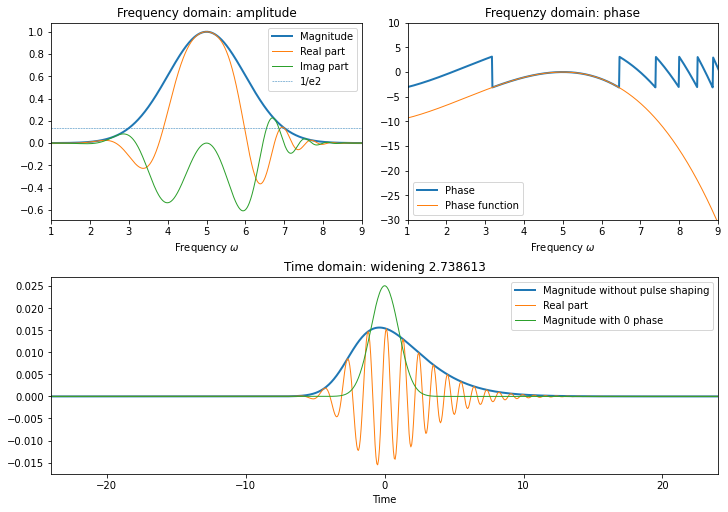

In [3]:
##  Plots

fig = plt.figure(figsize=(10, 7), layout="constrained")
spec = fig.add_gridspec(2, 2)

fig.add_subplot(spec[0, 0])
plt.plot(ww, abs(Aw), label = 'Magnitude', linewidth = 2)
plt.plot(ww, np.real(Aw), label = 'Real part', linewidth = 1)
plt.plot(ww, np.imag(Aw), label = 'Imag part', linewidth = 1)
plt.hlines(np.exp(-2), shaperLims[0], shaperLims[1], linestyles= "dashed", label= '1/e2', linewidth = 0.5)
plt.xlim(shaperLims)
plt.title("Frequency domain: amplitude")
plt.xlabel("Frequency $\omega$")
plt.legend()

fig.add_subplot(spec[0, 1])
plt.plot(ww, np.angle(Aw), label = 'Phase', linewidth = 2)
plt.plot(ww, phaseFunc(ww), label = 'Phase function', linewidth = 1)
plt.xlim(shaperLims)
plt.ylim(-30,10)
plt.title("Frequenzy domain: phase")
plt.xlabel("Frequency $\omega$")
plt.legend()

fig.add_subplot(spec[1, :])
plt.plot(tt, abs(at), label = 'Magnitude without pulse shaping', linewidth = 2)
plt.title('Time domain: widening {:2f}'.format(widthBefore / widthRef))
plt.xlim(6*(-4/sigma), (6* (4/sigma)))
plt.xlabel('Time')
plt.plot(tt, np.real(at), label = 'Real part', linewidth = 1)
plt.plot(tt, abs(atRef), label = 'Magnitude with 0 phase', linewidth = 1)
plt.legend()




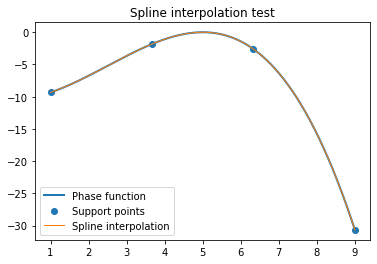

In [4]:
## Spline interpolation test
wws = np.linspace(shaperLims[0], shaperLims[1], nPix)
wSupp = np.linspace(shaperLims[0], shaperLims[1], S)
pp = scipy.interpolate.CubicSpline(wSupp, phaseFunc(wSupp))
plt.plot(wws, phaseFunc(wws), linewidth = 2, label = 'Phase function')
plt.scatter(wSupp, phaseFunc(wSupp), label = 'Support points')
plt.plot(wws, pp(wws), linewidth = 1, label = 'Spline interpolation')
plt.title('Spline interpolation test')
plt.legend()



In [5]:
## Optimization run
plotFunc = lambda x, optimValues: plotOptimState(x, optimValues, cfg, widthRef, pulseFormer)

test = lambda x, op: fminCallback(x, op, 50, plotFunc)

xopt, fopt, iterations, funcalls, warnflag = scipy.optimize.fmin(maxiter = 6000, maxfun = 50000, xtol = 1e-12, ftol = 1e-12, x0 = np.zeros(np.size(wSupp)), func = lambda p: targetFunc(p, wSupp, wws, pulseFormer, tt), full_output= True)


print('neuer Wert:{}'.format(fopt))
print('ref Wert:{}'.format(widthRef))





Optimization terminated successfully.
         Current function value: 0.707110
         Iterations: 428
         Function evaluations: 816
neuer Wert:0.7071100321203456
ref Wert:0.7071067817765326


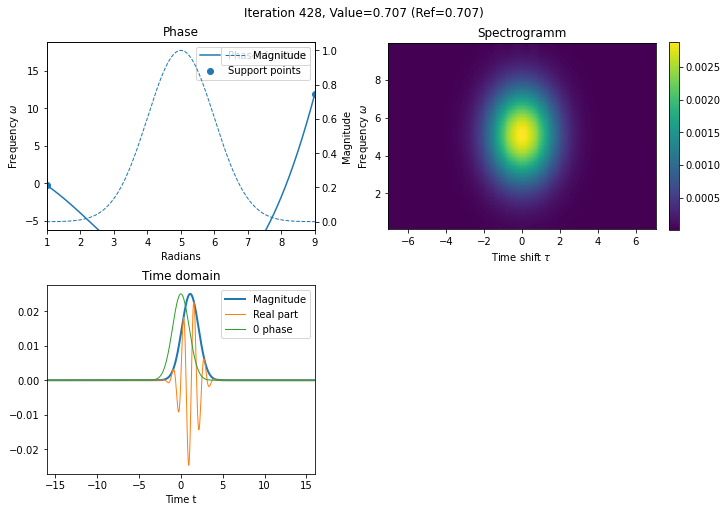

In [6]:
class optimValuesss(NamedTuple):
    iteration: int
    fval: float
    
optimValuess = optimValuesss(iterations,fopt)

plotFunc = lambda x, optimValues: plotOptimState(x, optimValues, cfg, widthRef, pulseFormer)
xopt1 = xopt
xopt2 = np.unwrap(xopt)
xopt3 = xopt % 2*np.pi
plotFunc(xopt,optimValuess)



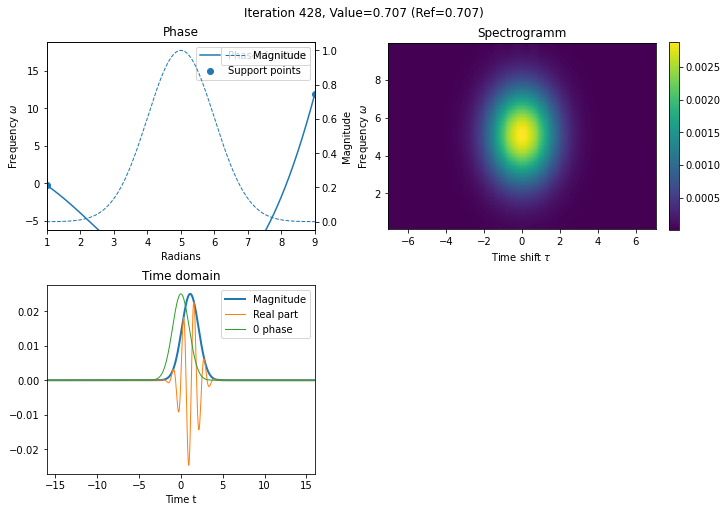

In [7]:
xopt
plotFunc(xopt1,optimValuess)

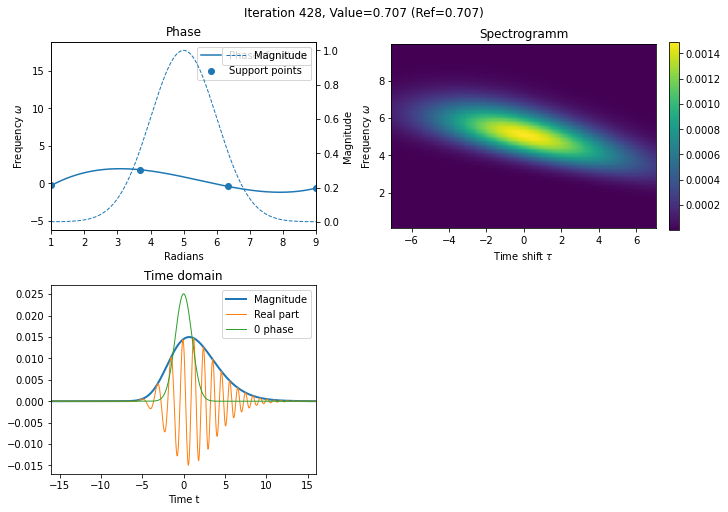

In [8]:
xopt
plotFunc(xopt2,optimValuess)

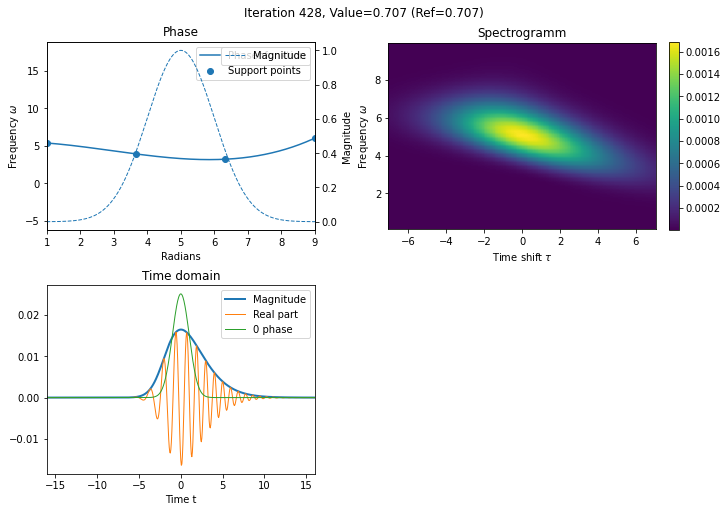

In [9]:
#xopt3 = xopt2 + 3*np.pi
plotFunc(xopt3,optimValuess)